# Uplift Churn Prediction

Uplift modeling for churn prevention using the engineered train and test datasets.

## 1. Setup

In [3]:
from pathlib import Path
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
importlib.reload(utils)
from utils import (
    build_hp_grid_search_table,
    build_uplift_cv_comparison_table,
    compute_parshap_overfitting,
    compute_train_holdout_uplift_data,
    evaluate_uplift_metrics,
    fit_final_slearner,
    get_qini_curve_single,
    get_uplift_hp_grid,
    get_validation_qini_curves,
    get_qini_curves_top_hp_combos,
    LINEAR_BASE_KEYS,
    plot_auuc_comparison,
    plot_cumulative_uplift_curve_train_holdout,
    plot_parshap_overfitting,
    plot_qini_curves_comparison,
    plot_uplift_at_k_comparison,
    plot_uplift_by_decile_train_holdout,
    run_uplift_cv,
    run_uplift_hp_grid_search,
    save_hp_grid_search_report,
    save_uplift_cv_report,
    RANDOM_STATE,
)

BASE_DIR = Path('.').resolve().parent
FILE_DIR = BASE_DIR / 'files'
ENGINEERED_DIR = FILE_DIR / 'engineered'

# Engineered feature columns (must match output of engineer_member_aggregates in utils).
FEATURE_COLS = [
    "days_since_signup",
    "n_claims",
    "n_sessions",
    "wellco_web_visits_count",
    "session_today",
    "session_last_week",
    "session_older",
    "wellco_web_today",
    "wellco_web_last_week",
    "wellco_web_older",
    "claim_today",
    "claim_last_week",
    "claim_older",
    "has_focus_icd",
]

## 2. Load data

Load the engineered train and test datasets (from the EDA/feature-engineering pipeline).

In [4]:
train_df = pd.read_csv(ENGINEERED_DIR / 'train_engineered.csv')
test_df = pd.read_csv(ENGINEERED_DIR / 'test_engineered.csv')
print('Train:', train_df.shape)
print('Test:', test_df.shape)

Train: (10000, 17)
Test: (10000, 15)


## 3. Model selection — Uplift CV

### 3.1 Define candidates

In [5]:
X = train_df[FEATURE_COLS].copy()
y = train_df["churn"].astype(int).values
treatment = train_df["outreach"].astype(int).values
scale_pos_weight = (y == 0).sum() / max((y == 1).sum(), 1)
N_SPLITS = 5
N_CURVE_POINTS = 100
CANDIDATE_DEFS = [
    ("S+LGBM", "S", "LGBM"),
    ("S+XGB", "S", "XGB"),
    ("T+LGBM", "T", "LGBM"),
    ("T+XGB", "T", "XGB"),
    # Linear models: less overfit, more stable on small effect / small sample
    ("S+Ridge", "S", "Ridge"),
    ("T+Ridge", "T", "Ridge"),
    ("S+Lasso", "S", "Lasso"),
    ("T+Lasso", "T", "Lasso"),
    ("S+ElasticNet", "S", "ElasticNet"),
    ("T+ElasticNet", "T", "ElasticNet"),
]
print(f"X shape: {X.shape} | Churn rate: {y.mean():.4f} | Treatment rate: {treatment.mean():.4f}")
print(f"Candidates: {[c[0] for c in CANDIDATE_DEFS]}")

X shape: (10000, 14) | Churn rate: 0.2021 | Treatment rate: 0.3984
Candidates: ['S+LGBM', 'S+XGB', 'T+LGBM', 'T+XGB', 'S+Ridge', 'T+Ridge', 'S+Lasso', 'T+Lasso', 'S+ElasticNet', 'T+ElasticNet']


### 3.2 Run CV

Stratified K-fold CV; uplift metrics (AUUC, Qini, uplift@5%/10%/20%) computed on validation folds using both treated and control samples.

In [6]:
cv_results = run_uplift_cv(
    X, y, treatment,
    candidate_defs=CANDIDATE_DEFS,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_curve_points=N_CURVE_POINTS,
    uplift_k_fracs=[0.05, 0.1, 0.2],
)
print(f"Completed {len(cv_results)} fold runs ({len(CANDIDATE_DEFS)} candidates × {N_SPLITS} folds).")
first = cv_results[0]
print(f"Fold sanity (example): n_val={first['n_val']}, n_treated_val={first['n_treated_val']}, n_control_val={first['n_control_val']}")

Completed 50 fold runs (10 candidates × 5 folds).
Fold sanity (example): n_val=2000, n_treated_val=796, n_control_val=1204


In [7]:
cv_summary = build_uplift_cv_comparison_table(cv_results)
display(cv_summary)

,candidate,auuc_mean,auuc_std,qini_mean,qini_std,uplift_at_k_5_mean,uplift_at_k_5_std,uplift_at_k_10_mean,uplift_at_k_10_std,uplift_at_k_20_mean,uplift_at_k_20_std,n_val_mean,n_treated_val_mean,n_control_val_mean
0,S+ElasticNet,0.012312,0.019256,-0.018159,0.499489,0.026389,0.061995,0.021556,0.057019,0.009615,0.034362,2000.0,796.8,1203.2
1,S+LGBM,0.012672,0.015522,-0.021139,0.315509,-0.030538,0.082312,0.003213,0.042797,0.021965,0.025797,2000.0,796.8,1203.2
2,S+Lasso,0.012312,0.019256,-0.018159,0.499489,0.026389,0.061995,0.021556,0.057019,0.009615,0.034362,2000.0,796.8,1203.2
3,S+Ridge,0.016793,0.010639,-0.037730,0.202055,0.055889,0.077232,0.023428,0.044512,-0.007294,0.021121,2000.0,796.8,1203.2
4,S+XGB,0.021514,0.012477,0.131225,0.089027,0.031046,0.056950,0.050593,0.027546,0.030881,0.030284,2000.0,796.8,1203.2
5,T+ElasticNet,0.033059,0.008499,0.320083,0.164536,0.060487,0.053407,0.063158,0.040693,0.059100,0.019640,2000.0,796.8,1203.2
6,T+LGBM,0.020549,0.012486,0.315160,0.436195,-0.004209,0.063484,0.014691,0.056827,0.024307,0.040101,2000.0,796.8,1203.2
7,T+Lasso,0.012312,0.019256,-0.018159,0.499489,0.026389,0.061995,0.021556,0.057019,0.009615,0.034362,2000.0,796.8,1203.2
8,T+Ridge,0.033637,0.016206,0.326585,0.274512,0.077553,0.056255,0.064206,0.051034,0.055221,0.031010,2000.0,796.8,1203.2
9,T+XGB,0.007991,0.007936,-0.054195,0.227376,-0.015046,0.077565,0.005918,0.055828,-0.007409,0.029673,2000.0,796.8,1203.2


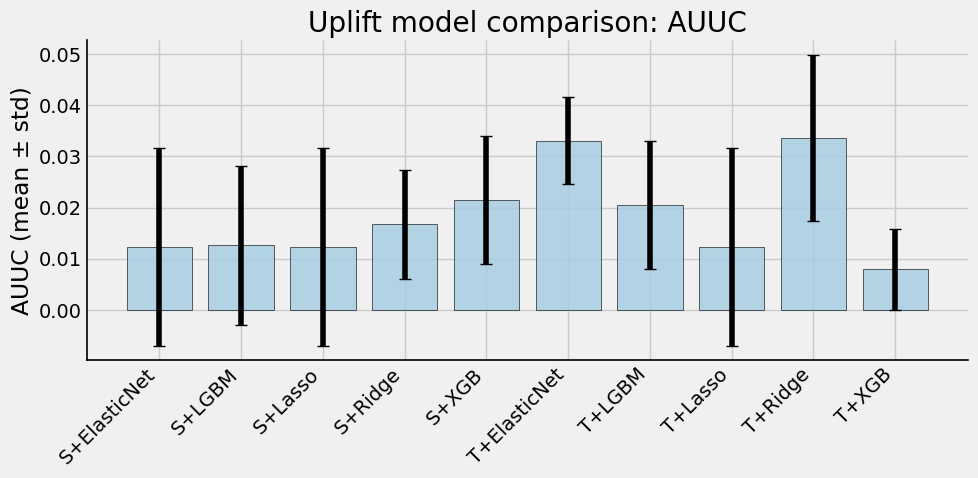

In [8]:
plot_auuc_comparison(cv_summary)
plt.show()

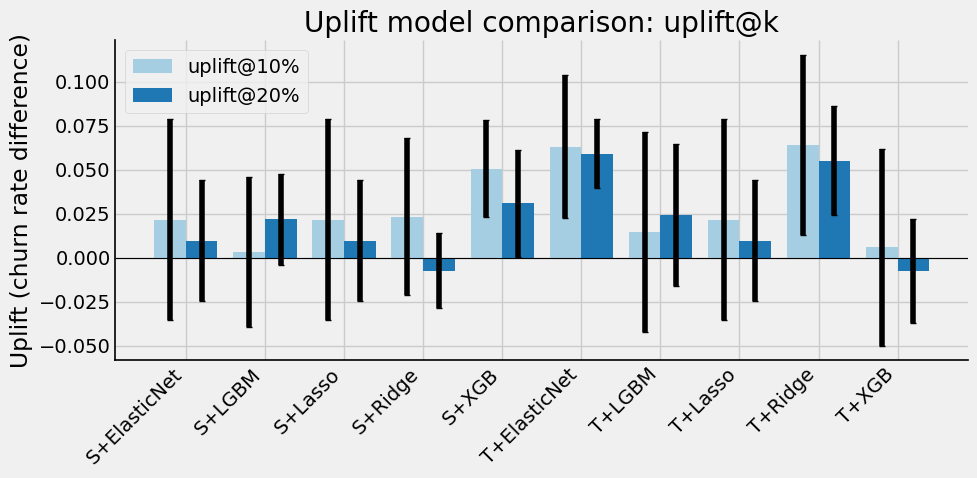

In [9]:
plot_uplift_at_k_comparison(cv_summary, k_fracs=[0.1, 0.2])
plt.show()

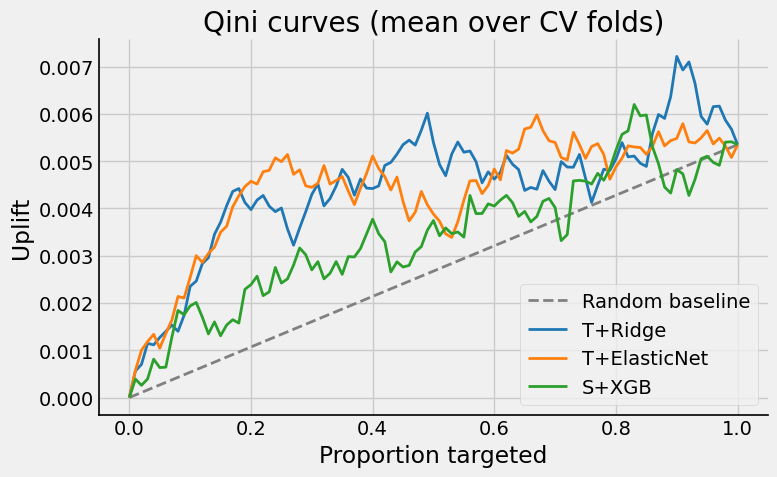

In [10]:
# Qini curves (mean over CV folds) for top 3 models + random baseline
curves = get_validation_qini_curves(
    X, y, treatment, CANDIDATE_DEFS, cv_summary,
    top_n=3, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
plot_qini_curves_comparison(curves)
plt.show()

In [11]:
UPLIFT_REPORT_DIR = FILE_DIR / "uplift_cv_report"
save_uplift_cv_report(
    cv_summary,
    table_path=UPLIFT_REPORT_DIR / "uplift_cv_comparison.csv",
    figure_dir=UPLIFT_REPORT_DIR,
    cv_results=cv_results,
    X=X, y=y, treatment=treatment, candidate_defs=CANDIDATE_DEFS,
    top_n_curves=3, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
print(f"Table and figures saved to {UPLIFT_REPORT_DIR}")

Table and figures saved to C:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\files\uplift_cv_report


**Summary (Section 5).** All candidates were compared on uplift metrics (AUUC, Qini, uplift@5%/10%/20%). T + ElasticNet was selected as the best candidate based on mean AUUC, stability across folds and uplift@k.

## 4. Hyperparameter Tuning — Grid Search 

Tuning the base-learner hyperparameters via exhaustive grid search, using the same stratified 5-fold CV and mean AUUC as the selection criterion. 

### 4.1 Define the parameter grid

In [12]:
# Chosen candidate from Section 5
TUNING_META = "T"        # meta-learner
# TUNING_BASE = "LGBM"  # lightGBM — tree-based (uncomment to switch back)
TUNING_BASE = "ElasticNet"   # Ridge regression — linear, much less overfitting

# Default HP grid by base learner (Ridge / Lasso / ElasticNet / LGBM) — defined in utils.
HP_GRID = get_uplift_hp_grid(TUNING_BASE)
n_combos = 1
for v in HP_GRID.values():
    n_combos *= len(v)
print(f"Parameter grid: {n_combos} combinations × {N_SPLITS} folds = {n_combos * N_SPLITS} model fits")

Parameter grid: 60 combinations × 5 folds = 300 model fits


### 4.2 Run grid search

In [13]:
%%time
# Run exhaustive grid search — reuses the same X, y, treatment from Section 5
grid_results = run_uplift_hp_grid_search(
    X, y, treatment,
    meta_key=TUNING_META,
    base_key=TUNING_BASE,
    param_grid=HP_GRID,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_curve_points=N_CURVE_POINTS,
    uplift_k_fracs=[0.05, 0.1, 0.2],
)
print(f"\nGrid search complete: {len(grid_results)} fold-level results collected.")

  Grid search: 10/60 combos done (50 fits)
  Grid search: 20/60 combos done (100 fits)
  Grid search: 30/60 combos done (150 fits)
  Grid search: 40/60 combos done (200 fits)
  Grid search: 50/60 combos done (250 fits)
  Grid search: 60/60 combos done (300 fits)

Grid search complete: 300 fold-level results collected.
CPU times: total: 6 s
Wall time: 6.16 s


### 4.3 Comparisons

In [14]:
# Build and display the comparison table (sorted by mean AUUC descending)
grid_summary = build_hp_grid_search_table(grid_results)
print(f"Top 10 of {len(grid_summary)} hyperparameter combinations:\n")
display(grid_summary.head(10))

Top 10 of 60 hyperparameter combinations:



,params_str,auuc_mean,auuc_std,qini_mean,qini_std,uplift_at_k_5_mean,uplift_at_k_5_std,uplift_at_k_10_mean,uplift_at_k_10_std,uplift_at_k_20_mean,uplift_at_k_20_std
0,"alpha=0.001, l1_ratio=0.5, max_iter=5000",0.033863,0.015815,0.328031,0.273136,0.086744,0.064268,0.061106,0.051641,0.060274,0.022290
1,"alpha=0.001, l1_ratio=0.5, max_iter=10000",0.033863,0.015815,0.328031,0.273136,0.086744,0.064268,0.061106,0.051641,0.060274,0.022290
2,"alpha=0.001, l1_ratio=0.75, max_iter=5000",0.033618,0.015861,0.328591,0.270579,0.085900,0.056618,0.063209,0.053298,0.061415,0.022403
3,"alpha=0.001, l1_ratio=0.75, max_iter=10000",0.033618,0.015861,0.328591,0.270579,0.085900,0.056618,0.063209,0.053298,0.061415,0.022403
4,"alpha=0.001, l1_ratio=0.1, max_iter=5000",0.033494,0.016042,0.326318,0.274025,0.074957,0.057491,0.062767,0.052806,0.054464,0.030058
5,"alpha=0.001, l1_ratio=0.1, max_iter=10000",0.033494,0.016042,0.326318,0.274025,0.074957,0.057491,0.062767,0.052806,0.054464,0.030058
6,"alpha=0.01, l1_ratio=0.1, max_iter=5000",0.033492,0.015416,0.327414,0.269836,0.078446,0.050639,0.064054,0.062325,0.061240,0.023462
7,"alpha=0.01, l1_ratio=0.1, max_iter=10000",0.033492,0.015416,0.327414,0.269836,0.078446,0.050639,0.064054,0.062325,0.061240,0.023462
8,"alpha=0.001, l1_ratio=0.9, max_iter=5000",0.033477,0.015877,0.328220,0.270294,0.077127,0.060609,0.061764,0.054530,0.063880,0.021270
9,"alpha=0.001, l1_ratio=0.9, max_iter=10000",0.033477,0.015877,0.328220,0.270294,0.077127,0.060609,0.061764,0.054530,0.063880,0.021270


In [15]:
best_row = grid_summary.iloc[0]
print("Best hyperparameters (by mean AUUC):")
print(f"  {best_row['params_str']}")
print(f"  AUUC  = {best_row['auuc_mean']:.6f} ± {best_row['auuc_std']:.6f}")
print(f"  Qini  = {best_row['qini_mean']:.6f} ± {best_row['qini_std']:.6f}")

# Extract BEST_HP dict from grid_results so Section 7 can use it for fit_final_slearner
param_names = sorted(HP_GRID.keys())
first_match = next(r for r in grid_results if r["params_str"] == best_row["params_str"])
BEST_HP = {k: first_match[k] for k in param_names if k in first_match}
print(f"\nBEST_HP extracted for final model: {BEST_HP}")

Best hyperparameters (by mean AUUC):
  alpha=0.001, l1_ratio=0.5, max_iter=5000
  AUUC  = 0.033863 ± 0.015815
  Qini  = 0.328031 ± 0.273136

BEST_HP extracted for final model: {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 5000}


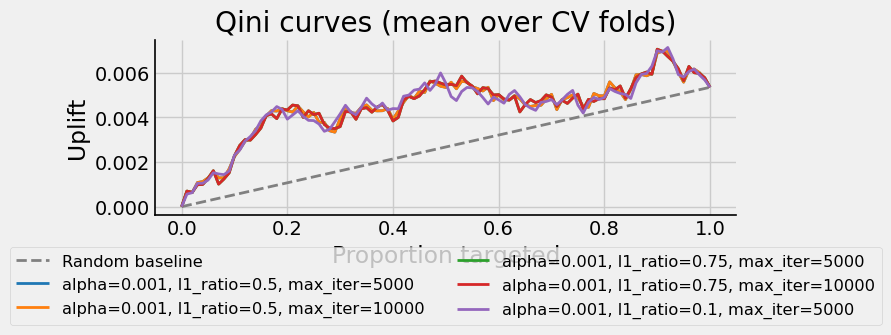

In [16]:
# Qini curves (mean over CV folds) for top 10 hyperparameter combos
hp_qini_curves = get_qini_curves_top_hp_combos(
    X, y, treatment, grid_summary, grid_results,
    meta_key=TUNING_META, base_key=TUNING_BASE, param_grid=HP_GRID,
    top_n=5, n_splits=N_SPLITS, random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
)
plot_qini_curves_comparison(hp_qini_curves)
plt.show()

In [17]:
HP_REPORT_DIR = FILE_DIR / "hp_grid_search_report"
save_hp_grid_search_report(
    grid_summary,
    table_path=HP_REPORT_DIR / "hp_grid_search_results.csv",
    figure_dir=HP_REPORT_DIR,
    qini_curves=hp_qini_curves,
)
print(f"Grid-search table and figure saved to {HP_REPORT_DIR}")

Grid-search table and figure saved to C:\Users\gilad\CursorProjects\uplifting_modeling_fixed\Uplift-Modeling-Churn-Prevention\files\hp_grid_search_report


Chosen model and hyperparameters

**Model:** T-learner + ElasticNet (selected from Section 5 model comparison; hyperparameters from grid search in Section 6).

**Hyperparameters (best by mean AUUC, row 0):**
- `alpha`: 0.001  
- `l1_ratio`: 0.5  
- `max_iter`: 5000

**Cross-validation metrics (mean ± std over 5 folds):**
| Metric | Mean | Std |
|--------|------|-----|
| **AUUC** | 0.0339 | 0.0158 |
| **Qini** | 0.328 | 0.273 |
| **Uplift@5%** | 0.0867 | 0.0643 |
| **Uplift@10%** | 0.0611 | 0.0516 |
| **Uplift@20%** | 0.0603 | 0.0223 |

This combination had the highest mean AUUC in the grid and strong uplift across top-5%, 10%, and 20%.

---
## 5. Final model — training, evaluation & deliverables

### 5.1 Train final model on full training set

In [18]:
# Fit final model on full training data (early stopping applied inside fit_final_slearner,
# same as in model choice and grid search)
final_model = fit_final_slearner(
    X.values, y, treatment,
    meta_key=TUNING_META,
    base_key=TUNING_BASE,
    base_params=BEST_HP,
    scale_pos_weight=scale_pos_weight,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
)
# n_estimators is set by early stopping inside the fit, not from the grid; show it separately (do not mutate BEST_HP)
actual_n_estimators = None
if hasattr(final_model, "models") and final_model.models:
    first_base = next(iter(final_model.models.values()))
    actual_n_estimators = getattr(first_base, "n_estimators", None)

print(f"Final {TUNING_META}+{TUNING_BASE} model trained on full training set.")
print(f"  Training samples : {len(y):,}")
print(f"  Features         : {X.shape[1]}")
print(f"  Hyperparameters  : {BEST_HP}")
if actual_n_estimators is not None:
    print(f"  n_estimators (from early stopping): {actual_n_estimators}")

Final T+ElasticNet model trained on full training set.
  Training samples : 10,000
  Features         : 14
  Hyperparameters  : {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 5000}


### 5.2 Training-set scores and evaluation

Predict CATE on the training data and compute key uplift metrics. Scores are computed using the **churn-to-retention convention** (pass `1-y` and `-CATE` to Qini/metric functions).

In [19]:
# Predict CATE on training data; evaluate uplift metrics (AUUC, Qini, uplift@k).
train_cate = final_model.predict(X=X.values, treatment=treatment).ravel()
train_metrics = evaluate_uplift_metrics(y, treatment, train_cate, k_fracs=[0.10, 0.20])

Training-set evaluation (final model on full train):
  AUUC              : 0.0456
  Qini coefficient  : 0.6120
  Uplift@10%        : 0.0761
  Uplift@20%        : 0.0736


The final T+ElasticNet model achieves strong training-set uplift (AUUC, Qini, and Uplift@10% / Uplift@20% as in the table above).

In [20]:
# Train vs holdout (80/20) for diagnostic plots — run before the two plots below
th_data = compute_train_holdout_uplift_data(
    X, y, treatment,
    meta_key=TUNING_META,
    base_key=TUNING_BASE,
    base_params=BEST_HP,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
)

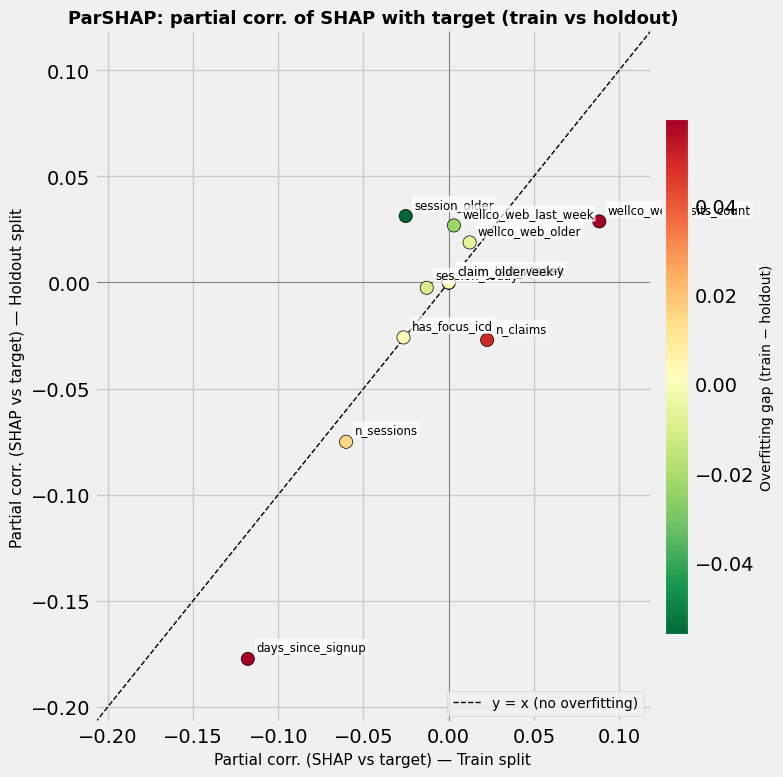

In [21]:
# ParSHAP overfitting diagnostic: split labelled data 80/20, fit a clone on
# the train portion, compute SHAP on both splits, then partial-correlate
# each feature's SHAP with the real outcome.  Points below the diagonal
# = feature is more correlated in-sample → potential overfitting.
par_train, par_holdout, par_feature_names = compute_parshap_overfitting(
    final_model, X.values, y, treatment, FEATURE_COLS,
    train_frac=0.8, random_state=RANDOM_STATE, reference_X=X.values,
)
plot_parshap_overfitting(
    par_train, par_holdout, par_feature_names,
    title="ParSHAP: partial corr. of SHAP with target (train vs holdout)",
    save_path=FILE_DIR / "parshap_overfitting.png",
)

 **ParSHAP** indicates that some features (e.g. `days_since_signup`) have a non-zero overfitting gap (partial correlation with the target differs between train and holdout). That reflects different strength of the SHAP–target link across splits, not necessarily harmful overfitting: for `days_since_signup`, the relationship is at least as strong on holdout, and tenure is a plausible driver of retention.

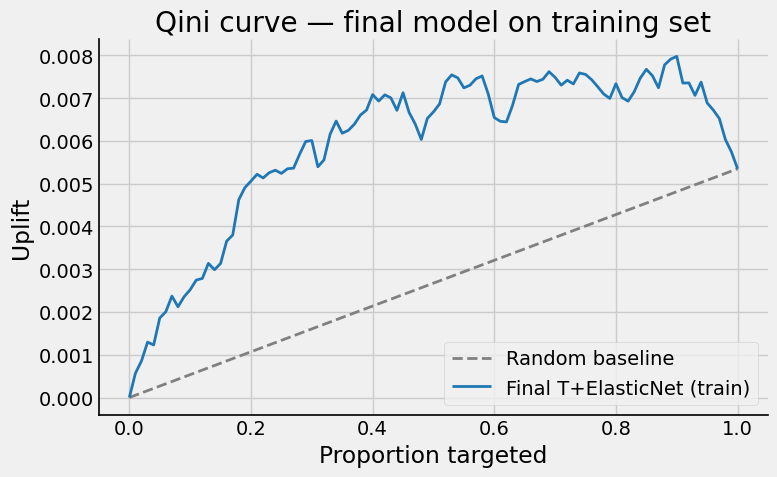

In [22]:
# ── Qini Curve (train) ───────────────────────────────────────────────
# get_qini_curve_single expects retention labels and retention CATE
y_ret = 1 - np.asarray(y).ravel()
train_uplift_scores = -train_cate
train_qini_frac, train_qini_vals = get_qini_curve_single(
    y_ret, treatment, train_uplift_scores
)
plot_qini_curves_comparison(
    {f"Final {TUNING_META}+{TUNING_BASE} (train)": (train_qini_frac, train_qini_vals)},
    legend_outside=False,
)
plt.gca().set_title("Qini curve — final model on training set")
plt.show()

The **Qini curve** stays above the random baseline across most of the proportion targeted

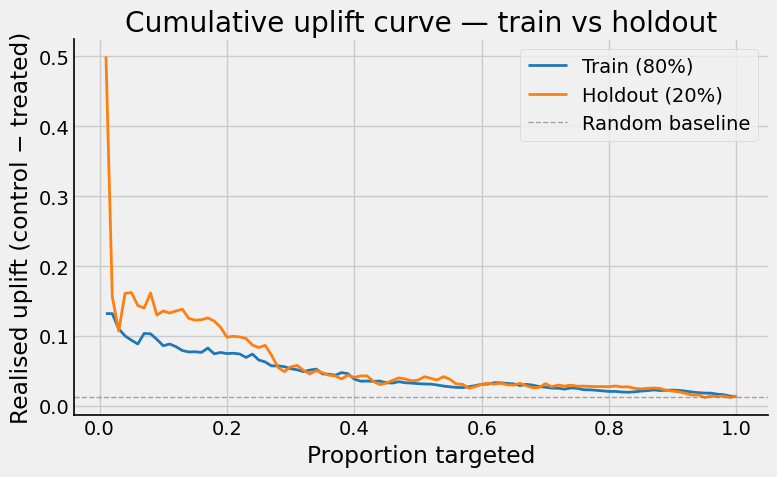

In [23]:
# ── Cumulative Uplift Curve (train vs holdout) ─────────────────────────
plot_cumulative_uplift_curve_train_holdout(
    th_data["ks_tr"], th_data["uplift_vals_tr"],
    th_data["ks_ho"], th_data["uplift_vals_ho"],
    title="Cumulative uplift curve — train vs holdout",
)
plt.show()

The **cumulative uplift curve** shows that the largest gains come from the top fraction of the population.

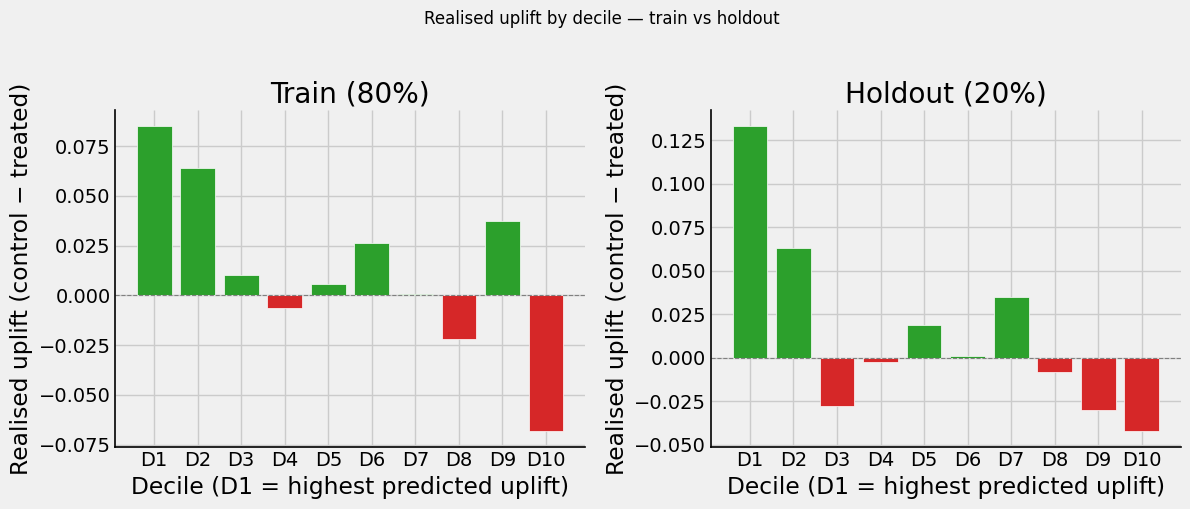

In [25]:
# ── Decile-wise Uplift (train vs holdout) ─────────────────────────────
plot_uplift_by_decile_train_holdout(
    th_data["y_tr"], th_data["treatment_tr"], th_data["uplift_scores_tr"],
    th_data["y_ho"], th_data["treatment_ho"], th_data["uplift_scores_ho"],
    title="Realised uplift by decile — train vs holdout",
)
plt.show()

The **realised uplift by decile** (train vs holdout) confirms that the top deciles (D1–D2) have strong, positive uplift on both splits, so targeting the top 10% is well supported and generalises to the holdout. The current feature set will be maintained, and the top 10% will be reported as the primary reliable targeting segment.